In [322]:
#Bibliotecas core
import pandas as pd
import numpy as np
import math

#Statsmodel para criação dos modelos de regressão linear e avaliação das métricas
import statsmodels.formula.api as sm
import statsmodels.api         as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

#SKLearn para o split da base, pipeline com transformação das colunas, criação do modelo RandomForest e avaliação do mesmo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, LearningCurveDisplay, ShuffleSplit
from sklearn.feature_selection import RFE

#Bibliotecas para plot
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração para mostrar os diagramas dos pipelines realizados com o SkLearn, apenas para melhorar a visualização de como o modelo está trabalhando.
from sklearn import set_config
set_config(display='diagram')


In [278]:
#Funções utilizadas posteriormente no código

#FUNÇÃO PARA CALCULAR O VIF
def calc_vif(dataframe):
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

#FUNÇÃO PARA EXIBIR AS MÉTRICAS DO MODELO
def imprimir_metricas (y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'MSE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, mse, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

def log_transform(x):
      return np.log(x+1)

<h2> 1. Leitura e processamento do dataframe </h2>

In [279]:
#A leitura é realizada a partir de uma base trabalhada anteriormente
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')
#df = df.drop(['MES_LAN', 'AGENTE', 'DATA_ENT', 'ZONA'], axis=1)

In [280]:
#Removi colunas que não seriam de nenhum interesse para o modelo (como ID e as "Unnamed") e também colunas de preço. Pensando que os preços devem ser altamente correlacionados, deixar 
#Valores na base não traria uma leitura muito interpretativa

#Base que será utilizada para o split 
df_rf = df.drop(['Unnamed: 0.1', 'Unnamed: 0',
       'RENRESP00', 'ID', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'PC_AT_ATU','ANO_LAN', 'MES_LAN',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'PC_M2_AT_log', 'VLR_US__CO_log', 'PCMEDAU10_log', 'PC_M2_AU_log', 
       'DATA_ENT','PERC_PPI', 'PERC_4_MAIS_MORADORES',
       'Brancos', 'Pretos', 'Amarelos', 'Pardos', 'Índigenas', 'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 moradores','Domicilios 4 ou mais moradores', 'Residentes no setor censitário', 'SC_2010', 'AP2010', 'BANH_DORM', 'Domicílios_Setor',
       'UNIDAND', 'DORM_EMP',  'BLOCOS', 'Média_Moradores_por_domicilio_setor', 'REGIAO', 
       ], axis=1)

df['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df['RENRESP10_log'] = np.log(df['RENRESP10'])

df_rf['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df_rf['RENRESP10_log'] = np.log(df['RENRESP10'])

<h3>1.1 Definindo as variáveis que estarão presentes no modelo</h3>

In [281]:
#Indicação das targets de cada modelo
target_au = 'PC_AU_ATU' #Target: Preço da área útil 
target_tt = 'PC_TT_ATU' #Target: Preço total da unidade

#As variáveis numéricas e categóricas que acabam sendo utilizadas posteriormente nos modelos de regressão linear
numericas = ['ANO_LAN', 'DORM_UNID', 'BANH_DORM', 'AR_UT_UNID']
categoricas = ['REGIAO', 'TIPO_EMP', 'AGENTE', 'CONSTRUTOR']
features = numericas + categoricas

#Variáveis que serão utilizadas no modelo de RF
numericas2 = df_rf.select_dtypes(['int', 'float']).columns
numericas2 = numericas2.drop(['PC_AU_ATU', 'PC_TT_ATU', 'PC_AU_ATU_log', 'PC_TT_ATU_log'])
categoricas2 = df_rf.select_dtypes(['object', 'string']).columns

#unidade = ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID', 'PC_TT_ATU']
#df_rf2 = df[unidade]

In [282]:
X_train_tt.columns

Index(['TIPO_EMP', 'DIST', 'SUBPREF', 'MUNICIPIO', 'TIT_VIA', 'TIPO_VIA',
       'ZONA', 'DORM_UNID', 'AR_UT_UNID_log', 'RENRESP10_log'],
      dtype='object')

In [283]:
#Preenchendo as variáveis categóricas com o valor mais frequente, realizando isso para evitar posteriores erros no RF
for col in categoricas2:
    df[col] = df[col].fillna(df[col].mode())

#Realizando label encoder nas variáveis dos modelos de regressão linear
for col in categoricas:
    df[col] = LabelEncoder().fit_transform(df[col].array.reshape(-1, 1))

C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

In [284]:
'''for col in unidade:
    df_rf2[col] = df_rf2[col].fillna(df_rf2[col].mode())'''

'for col in unidade:\n    df_rf2[col] = df_rf2[col].fillna(df_rf2[col].mode())'

In [285]:
q1 = np.percentile(df_rf[target_tt], 25)
q3 = np.percentile(df_rf[target_tt], 75)
iqr = q3 - q1

# Calculate the upper and lower bounds
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
    
# Remove outliers
df_rf = df_rf[(df_rf[target_tt] >= limite_inferior) & (df_rf[target_tt] <= limite_superior)]

In [286]:
df_rf.shape

(15377, 49)

In [287]:
#Train_Test split
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop([target_au, target_tt, 'PC_TT_ATU_log', 'PC_AU_ATU_log'], axis=1), df_rf[target_au], test_size=0.2)
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(df_rf.drop([target_au, target_tt, 'PC_TT_ATU', 'PC_AU_ATU_log'], axis=1), df_rf[target_tt], test_size=0.2)

<h2>2. Interpretando a formulação dos preços dos imóveis - Modelos de regressão linear </h2>

O modelo de regressão linear permite maior interpretabilidade das variáveis e da constituição do preço dos empreendimentos lançados. Contém alguma perda de performance em relação aos modelos mais avançados, como ensembles de Random Forest, mas são mais facilmente lidos.

<h3>2.1 - Criando o baseline</h3>
No modelo baseline foram consideradas variáveis que são intuitivamente conhecidas na descrição de um empreendimento imobiliário, como o número de dormitórios, o número de banheiros e a área do apartamento.

In [288]:
#Criando os modelos baseline do preço da área útil e da área total. A ideia é que os modelos posteriores consigam um R² maior e AIC/BIC menores
au_baseline = sm.ols(formula='PC_AU_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
tt_baseline = sm.ols(formula='PC_TT_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()

tt_baseline.summary()
#tt_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_TT_ATU_log   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     5037.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:46:23   Log-Likelihood:                -6957.9
No. Observations:               12301   AIC:                         1.392e+04
Df Residuals:                   12297   BIC:                         1.395e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8803      0.013    915.894      0.000      11.855      11.906
DORM_UNID     -0.1227      0.008    -15.930      0.000      -0.138      -0.108
BANH_UNID      0.2849      0.009     30.158      0.000       0.266       0.303
AR_UT_UNID     0.0086      0.000     52.679      0.000       0.008       0.009
==============================================================================
Omnibus:                       40.226   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.471
Skew:                           0.137   Prob(JB):                     1.63e-09
Kurtosis:                       2.934   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Percebe-se que as variáveis relacionadas apenas ao apartamento não explicam bem, sozinhas, a variação do preço da área útil. O grau de explicabilidade das variáveis se mantém abaixo dos 20% para o caso da variável resposta em forma absoluta e logarítimica. 

O estudo sobre a dinâmica imobiliária no mercado de São Paulo leva ao entendimento de que duas variáveis são cruciais para o entendimento do preço das unidades: O local do empreendimento e o ano de lançamento. O local do empreendimento importa porque uma cidade desigual como São Paulo contém uma alta variabilidade no preço da terra, que se reflete diretamente nos valores de compra e venda de aluguéis dos imóveis; o ano de lançamento mantém relações com a macroeconomia, no sentido de que embora a demanda por moradia sempre seja alta, em anos de boom econômico a oferta e a disponibilidade de renda crescem exponencialmente. 
A seguir, essas duas variáveis são inseridas no modelo da resposta logarítimica do preço da área útil da unidade. 

<h3>2.2 - Otimizando os modelos</h3>

In [289]:
#Variáveis utilizadas em cada um dos modelos
variaveis_au =['REGIAO', 'BANH_DORM', 'AR_UT_UNID', 'TIPO_EMP', 'RENRESP10_log', 'CONSTRUTOR', 'AGENTE']
variaveis_tt = ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID']

#Modelos de regressão da área útil e total da unidade
regressao_au = sm.ols(formula='PC_AU_ATU_log ~ REGIAO + BANH_DORM + AR_UT_UNID + TIPO_EMP + RENRESP10_log + AGENTE', data=df.iloc[X_train.index,:]).fit()
regressao_tt = sm.ols(formula='PC_TT_ATU_log ~ DORM_UNID + REGIAO + RENRESP10_log + AR_TT_UNID', data=df.iloc[X_train.index,:]).fit()            

regressao_tt.summary()
#regressao_tt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_TT_ATU_log   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     7787.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:46:23   Log-Likelihood:                -4124.5
No. Observations:               12301   AIC:                             8259.
Df Residuals:                   12296   BIC:                             8296.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.6992      0.048    181.333      0.000       8.605       8.793
DORM_UNID         0.0467      0.006      8.318      0.000       0.036       0.058
REGIAO           -0.0096      0.001     -8.572      0.000      -0.012      -0.007
RENRESP10_log     0.4240      0.006     72.947      0.000       0.413       0.435
AR_TT_UNID        0.0044   5.98e-05     74.229      0.000       0.004       0.005
==============================================================================
Omnibus:                        1.411   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.378
Skew:                          -0.022   Prob(JB):                        0.502
Kurtosis:                       3.027   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>2.3 - Verificando os requisitos de aceitabilidade do modelo</h3>

<h4>2.3.1 Multicolinearidade - Correlação entre variáveis e Variance Inflation Factor</h4>

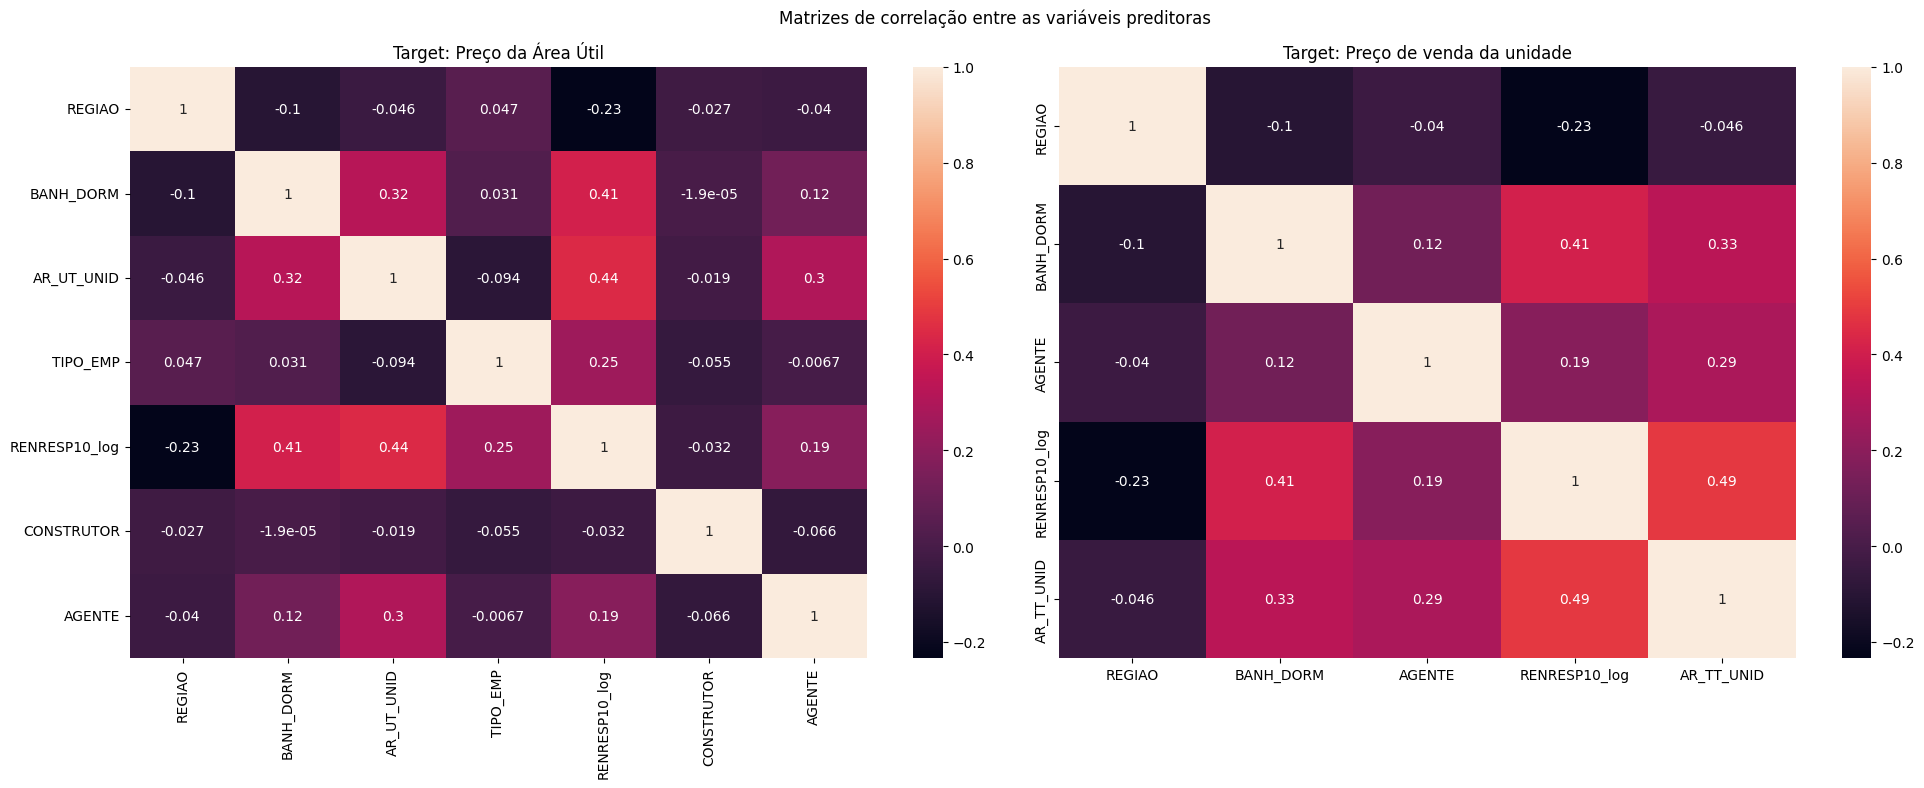

In [290]:
#Plotando as matrizes de correlação para identificar variáveis possivelmente muito relacionadas
fig, axs = plt.subplots(1, 2, figsize=(20,8), facecolor='white') 
axs1 = sns.heatmap(df[variaveis_au].corr(), annot=True, ax=axs[0])
axs2 = sns.heatmap(df[variaveis_tt].corr(), annot=True, ax=axs[1])

axs1.set_title(label='Target: Preço da Área Útil')
axs2.set_title(label='Target: Preço de venda da unidade')
fig.suptitle('Matrizes de correlação entre as variáveis preditoras')
fig.tight_layout()

In [291]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif_tt = calc_vif(df[variaveis_tt])
#print('vars: ', variaveis_tt)
print('Unidade - Variable Inflation Factors:', vif_tt.VIF.sum(), '\n')

vif_au = calc_vif(df[variaveis_au])
#print('vars: ', variaveis_au)
print('Área Útil - Variable Inflation Factors:', vif_au.VIF.sum(), '\n')


Unidade - Variable Inflation Factors: 52.46571408568083 

Área Útil - Variable Inflation Factors: 79.50374093205095 



<h4>2.3.2 Verificando heteroscedasticidade e normalização/distribuição dos resíduos</h4>

Text(0.51, 0.9, '(VIF - Valor da área útil: 79.5)')

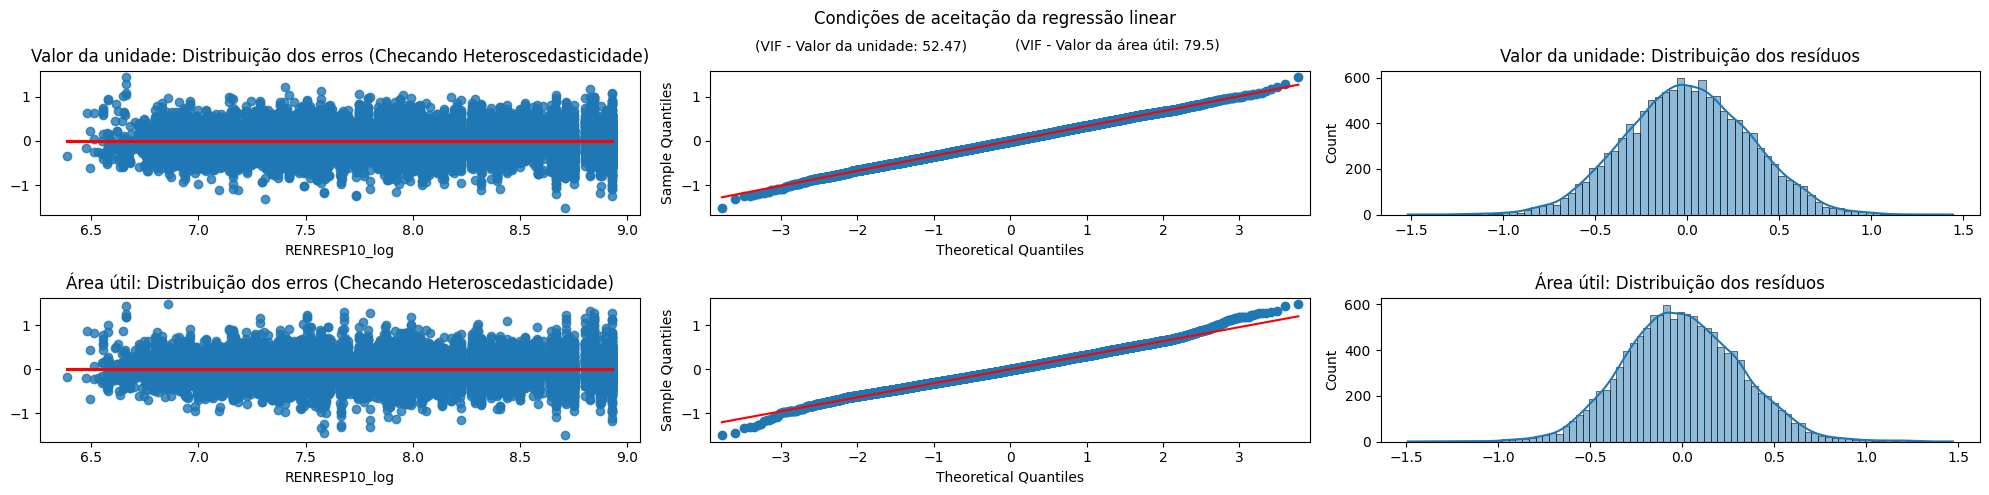

In [292]:

#Criando os subplots dos testes das regressões
fig, axs = plt.subplots(2, 3, figsize=(20,5), facecolor='white') 
ax00 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_tt.resid, ax=axs[0,0], line_kws={'color':'red'})
ax01 = sma.qqplot(regressao_tt.resid, line="s", ax=axs[0,1])
ax02 = sns.histplot(regressao_tt.resid, kde=True, ax=axs[0,2])
ax10 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_au.resid, ax=axs[1,0], line_kws={'color':'red'})
ax11 = sma.qqplot(regressao_au.resid, line="s", ax=axs[1,1])
ax12 = sns.histplot(regressao_au.resid, kde=True, ax=axs[1,2])

#Títulos dos subplots
ax00.set_title('Valor da unidade: Distribuição dos erros (Checando Heteroscedasticidade)')
ax01.suptitle('Valor da unidade: Distribuição dos resíduos (QQPlot)')
ax02.set_title('Valor da unidade: Distribuição dos resíduos')
ax10.set_title('Área útil: Distribuição dos erros (Checando Heteroscedasticidade)')
ax11.suptitle('Área útil: Distribuição dos resíduos (QQPlot)')
ax12.set_title('Área útil: Distribuição dos resíduos')

#Título geral
fig.suptitle('Condições de aceitação da regressão linear')
fig.tight_layout()
fig.text(s='(VIF - Valor da unidade: {})'.format(round(vif_tt.VIF.sum(), 2)), y=0.90, x=0.38)
fig.text(s='(VIF - Valor da área útil: {})'.format(round(vif_au.VIF.sum(), 2)), y=0.90, x=0.51)

<h2>3. Descobrindo os valores de m² e unidade - Modelos de RandomForest </h2>

In [293]:
#le = LabelEncoder()
#for col in categoricas2:
#    df_rf[col] = le.fit_transform(df_rf[col])

le = LabelEncoder()
for col in X_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist():
    X_train_tt[col] = le.fit_transform(X_train_tt[col])
    X_test_tt[col] = le.fit_transform(X_test_tt[col])
    print(col)

TIPO_EMP
DIST
SUBPREF
MUNICIPIO
TIT_VIA
TIPO_VIA
ZONA
SIST_FINAN
AGENTE
INCORPORAD
CONSTRUTOR
INCORPOR_A
CONSTRUT_A


<h4>3.1 - Criação de pipelines para adequação das features e criação do primeiro modelo</h4>

In [300]:
#Instanciando os pipelines de tratamento das variáveis do dataframe

#Tratamento categórico: Labelizando variáveis
le = LabelEncoder()
for col in X_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist():
    X_train_tt[col] = le.fit_transform(X_train_tt[col])
    X_test_tt[col] = le.fit_transform(X_test_tt[col])

#Tratamento numérico: input de dados faltantes e scaler 
num_pipeline = Pipeline(steps=[
    ("input", SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ])

#Column transformar aplicando os pipelines em todas as variáveis indicadas anteriormente
preprocessing = ColumnTransformer(transformers=[
    ('preprocessamento numerico', num_pipeline, numericas2)
])

#Pipeline do modelo de RandomForest aplicando o pré-processamento 
for algorithm in [ RandomForestRegressor,SGDRegressor, HistGradientBoostingRegressor]:
        model = Pipeline(steps=[('Preprocessamento', preprocessing),
        ('regressao', algorithm(random_state=42))])
        model.fit(X_train_tt, y_train_tt) #inserir ou remover o _tt
        y_pred = model.predict(X_test_tt) 
        rmse = math.sqrt(mean_squared_error(y_test_tt, y_pred))
        #rmse_exp = np.exp(rmse_log) #Usar em caso de log

        print('RMSE ({}): {:.2f}'.format(algorithm.__name__, rmse, 2))


RMSE (RandomForestRegressor): 90222.94
RMSE (SGDRegressor): 205396631731741.62
RMSE (HistGradientBoostingRegressor): 51230.32


In [301]:
model.fit(X_train_tt, y_train_tt) #Colocar ou retirar _tt dependendo do modelo
y_pred = model.predict(X_test_tt) #Colocar ou retirar _tt dependendo do modelo

baseline_report = imprimir_metricas(y_test_tt, y_pred) #Colocar ou retirar _tt dependendo do modelo
baseline_report

#Baseline - HGRadient Boost:
#'''RMSE	        71220
#	MAE	            43754
#	R^2	            0.98
#	MAPE	        0.09
#	Avg. target	    571528
#	Avg. Prediction	570407'''

,metric,valid
0,RMSE,5.123032e+04
1,MAE,3.066185e+04
2,MSE,2.624545e+09
3,R^2,9.700000e-01
4,MAPE,8.000000e-02
5,Avg. target,4.365469e+05
6,Avg. Prediction,4.346531e+05


<h4>3.2 - Verificando overfitting por meio de validação cruzada</h4>

In [302]:
#Relizando o cross validation para identificar possível overfitting no modelo
scores = cross_val_score(model, X_train_tt, y_train_tt, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) #Colocar ou retirar o _tt a depender do modelo
print("RMSE: %0.2f (%0.2f%%) (+/- %0.2f)" % (np.sqrt(abs(scores.mean())), ((np.sqrt(abs(scores.mean()))/np.mean(y_pred))*100) ,np.sqrt(scores.std()) * 2))

#'''Valor da unidade:      HGBoost - RMSE: 72282.02 (12.46%) (+/- 30511.45)


RMSE: 50965.62 (11.73%) (+/- 30107.01)


<h4>3.3 - Hiperparametrização - selecionando o melhor conjunto de parâmetros para o modelo a partir de Random/Grid Search</h4>

In [303]:
#Verificando os parâmetros default do RandomForest
print('Parâmetros default: \n')
print(model[1].get_params())

Parâmetros default: 

{'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [304]:
#Estabelecendo alguns limites para o random_grid trabalhar em cima e fazer uma pré-seleção dos melhores parâmetros

#Número máximo de estimadores
max_iter = [int(x) for x in np.linspace(start=100, stop=1000, num=20)]
#Alpha da regressão de Ridge 
l2_regularization = [int(x) for x in np.linspace(start=0, stop=100, num=20)]
#Profundidade de cada árvore
max_depth = [int(x) for x in np.linspace(1, 100, 10)]
#Número mínimo de folhas
min_samples_leaf = [5, 10, 20, 40, 100]
#Taxa de aprendizagem
learning_rate=[float(x) for x in np.linspace(start=0.1, stop=1, num=10)]

random_grid = {'regressao__max_iter': max_iter,
               'regressao__l2_regularization': l2_regularization,
               'regressao__max_depth': max_depth,
               'regressao__min_samples_leaf': min_samples_leaf,
               'regressao__learning_rate': learning_rate 
                }
print(random_grid)

{'regressao__max_iter': [100, 147, 194, 242, 289, 336, 384, 431, 478, 526, 573, 621, 668, 715, 763, 810, 857, 905, 952, 1000], 'regressao__l2_regularization': [0, 5, 10, 15, 21, 26, 31, 36, 42, 47, 52, 57, 63, 68, 73, 78, 84, 89, 94, 100], 'regressao__max_depth': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100], 'regressao__min_samples_leaf': [5, 10, 20, 40, 100], 'regressao__learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]}


In [305]:
#Rodando o modelo de pré-seleção dos hiperparâmetros
modeL_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
modeL_random.fit(X_train_tt, y_train_tt) #Adicionar ou retirar o _tt conforme modelo

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessamento',
                                              ColumnTransformer(transformers=[('preprocessamento '
                                                                               'numerico',
                                                                               Pipeline(steps=[('input',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['DORM_UNID', 'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'BANH_EMP',
       'GAR_E...
                                                                         63, 68,
                                                                         73, 78,
                                                                         84, 89,
                                                                         94,
                                                                         100],
                                        'regressao__learning_rate': [0.1, 0.2,
                                                                     0.30000000000000004,
                                                                     0.4, 0.5,
                                                                     0.6,
                                                                     0.7000000000000001,
                                                                     0.8, 0.9,
                                                                     1.0],
                                        'regressao__max_depth': [1, 12, 23, 34,
                                                                 45, 56, 67, 78,
                                                                 89, 100],
                                        'regressao__max_iter': [100, 147, 194,
                                                                242, 289, 336,
                                                                384, 431, 478,
                                                                526, 573, 621,
                                                                668, 715, 763,
                                                                810, 857, 905,
                                                                952, 1000],
                                        'regressao__min_samples_leaf': [5, 10,
                                                                        20, 40,
                                                                        100]},
                   random_state=42)

In [307]:
modeL_random.best_params_

#HGboost:
#'''{'regressao__min_samples_leaf': 40,
# 'regressao__max_iter': 715,
# 'regressao__max_depth': 23,
# 'regressao__learning_rate': 0.1,
# 'regressao__l2_regularization': 57}'''

{'regressao__min_samples_leaf': 40,
 'regressao__max_iter': 715,
 'regressao__max_depth': 23,
 'regressao__learning_rate': 0.1,
 'regressao__l2_regularization': 57}

In [308]:
#FAZENDO O GRID SEARCH
#GRID DO PREÇO DA UNIDADE
param_grid = {'regressao__max_iter': [700, 800],
               'regressao__l2_regularization': [int(x) for x in np.linspace(start=55, stop=75, num=3)],
               'regressao__max_depth': [int(x) for x in np.linspace(start=20, stop=40, num=3)],
               'regressao__min_samples_leaf': [int(x) for x in np.linspace(start=20, stop=40, num=3)],
               'regressao__learning_rate': [0.1, 0.05] #Apenas em GBosst
                }


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_tt, y_train_tt) #Retirar ou colocar o _tt dependendo de qual modelo está sendo trabalhado

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessamento',
                                        ColumnTransformer(transformers=[('preprocessamento '
                                                                         'numerico',
                                                                         Pipeline(steps=[('input',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['DORM_UNID', 'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'BANH_EMP',
       'GAR_EMP', 'A...
       'PERC_UNIPESSOAIS', 'PERC_2_3_MORADORES', 'PERC_BRANCOS',
       'RENRESP10_log', 'AR_UT_UNID_log'],
      dtype='object'))])),
                                       ('regressao',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressao__l2_regularization': [55, 65, 75],
                         'regressao__learning_rate': [0.1, 0.05],
                         'regressao__max_depth': [20, 30, 40],
                         'regressao__max_iter': [700, 800],
                         'regressao__min_samples_leaf': [20, 30, 40]})

In [309]:
grid_search.best_params_

{'regressao__l2_regularization': 65,
 'regressao__learning_rate': 0.1,
 'regressao__max_depth': 20,
 'regressao__max_iter': 800,
 'regressao__min_samples_leaf': 30}

In [310]:
grid_search.best_params_

'''Valor da Unidade (RandomForest):
{'regressao__bootstrap': True,
 'regressao__max_depth': 45,
 'regressao__max_features': 0.5,
 'regressao__min_samples_split': 6,
 'regressao__n_estimators': 60}'''

'''Valor do m² de área útil (RandomForest):
 {'regressao__bootstrap': True,
 'regressao__max_depth': 50,
 'regressao__max_features': 0.5,
 'regressao__min_samples_split': 2,
 'regressao__n_estimators': 80}'''

'''Valor do m² de área útil (HistGradientBoost):
 {'regressao__min_samples_leaf': 30,
 'regressao__max_iter': 800,
 'regressao__max_depth': 20,
 'regressao__learning_rate': 0.1,
 'regressao__l2_regularization': 65}'''

"Valor do m² de área útil (HistGradientBoost):\n {'regressao__min_samples_leaf': 30,\n 'regressao__max_iter': 800,\n 'regressao__max_depth': 20,\n 'regressao__learning_rate': 0.1,\n 'regressao__l2_regularization': 65}"

In [311]:
grid_search.best_params_
best_estimator = grid_search.best_estimator_
random_estimator = modeL_random.best_estimator_


<h2>4. Rodando o modelo na base de teste e verificando a performance </h2>

In [312]:
y_pred = best_estimator.predict(X_test_tt) #Colocar ou retirar _tt dependendo do modelo

baseline_report = imprimir_metricas(y_test_tt, y_pred) #Colocar ou retirar _tt dependendo do modelo
baseline_report


,metric,valid
0,RMSE,4.172447e+04
1,MAE,2.304602e+04
2,MSE,1.740931e+09
3,R^2,9.800000e-01
4,MAPE,5.000000e-02
5,Avg. target,4.365469e+05
6,Avg. Prediction,4.354980e+05


In [315]:
score_final = cross_val_score(best_estimator, X_train_tt, y_train_tt, cv=100, scoring='neg_mean_squared_error', n_jobs=-1) #Colocar ou retirar o _tt a depender do modelo
print("RMSE: %0.2f (%0.2f%%) (+/- %0.2f)" % (np.sqrt(abs(score_final.mean())), ((np.sqrt(abs(score_final.mean()))/np.mean(y_pred))*100) ,np.sqrt(score_final.std()) * 2))

#   MODELO HGRADIENT BOOST - RMSE: 59090.99 (10.34%) (+/- 27568.21)

RMSE: 40369.46 (9.27%) (+/- 49410.55)


<AxesSubplot: ylabel='PC_TT_ATU'>

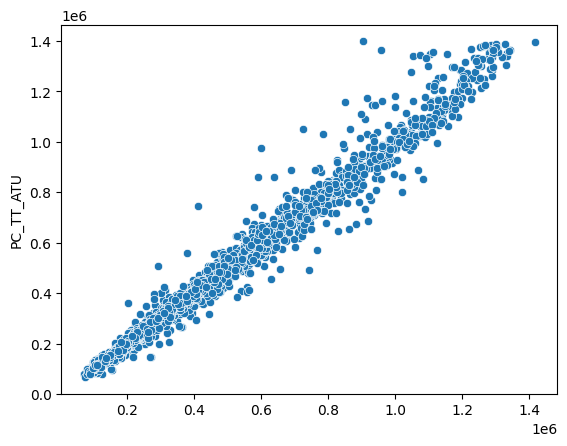

In [316]:
sns.scatterplot(x=y_pred, y=y_test_tt)

<h2>5 - Apêndice - Encontrando features desinteressantes</h2>

In [719]:
# Calculate the correlation matrix
corr_matrix = df.corr()
selected_cols = corr_matrix['PC_TT_ATU'].sort_values(ascending=True)[:20].index.tolist()
selected_cols

C:\Users\Pichau\AppData\Local\Temp\ipykernel_7704\3991328499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


['PERC_PPI',
 'Pardos',
 'UNIDAND',
 'Pretos',
 'TT_UNID',
 'Unnamed: 0.1',
 'Total de filhos dos responsáveis de domicílios',
 'Domicilios alugados',
 'DORM_EMP',
 'Residentes no setor censitário',
 'Unnamed: 0',
 'Domicilios 4 ou mais moradores',
 'Média_Moradores_por_domicilio_setor',
 'ANO_LAN',
 'PERC_ALUGADOS',
 'BLOCOS',
 'ID',
 'REGIAO',
 'Domicílios_Setor',
 'Domicilios 2 ou 3 moradores']

In [101]:
feature_importances = best_estimator[1].feature_importances_

AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

In [125]:
permutation_result = permutation_importance(best_estimator, X_test, y_test, n_repeats=30) #Alterar _tt conforme modelo

In [126]:
df_importancia = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)

Text(0.5, 0.98, 'Variáveis mais importantes no entendimento dos valores de residências vendidas')

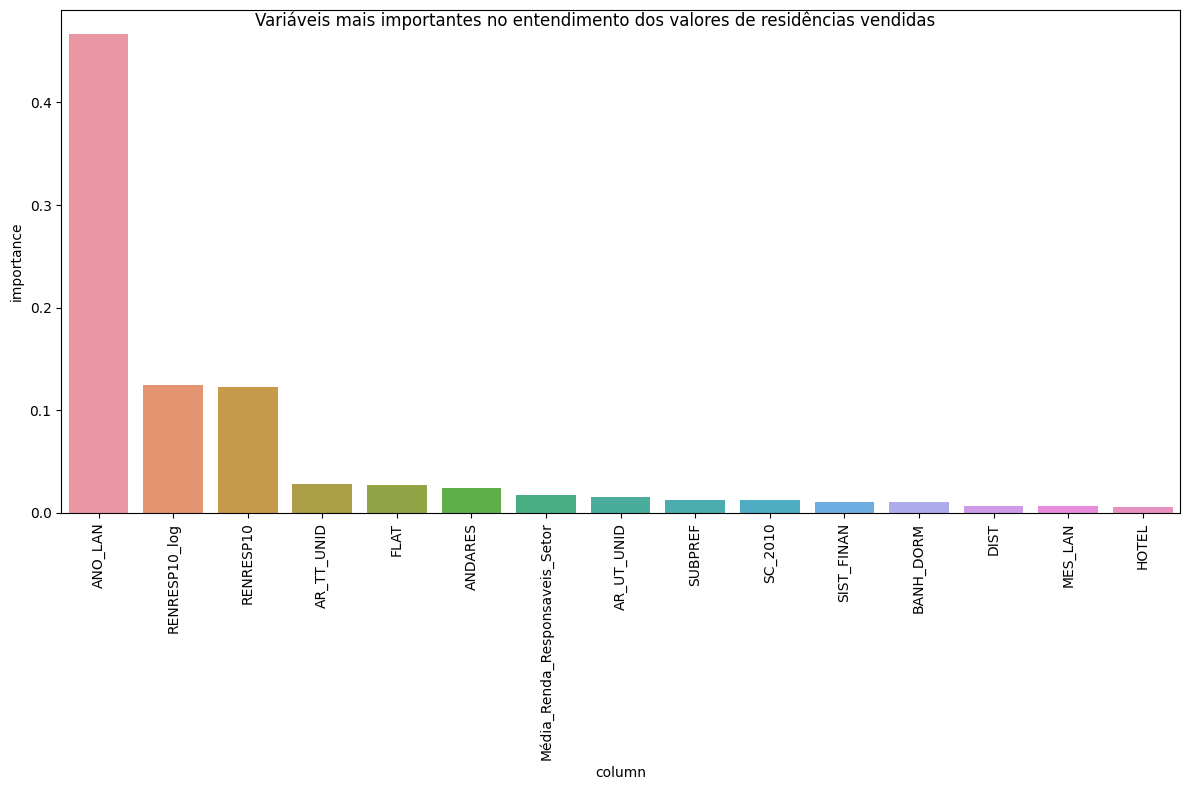

In [127]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

Conjunto 1: 0.65 (RandomF), 0.39 (RegressãoL)
Conjunto IBGE: 0.53 (RandomF), 0.26 (RegressãoL)
Conjunto 1_log: 0.69 (RandomF), 0.40 (RegressãoL)

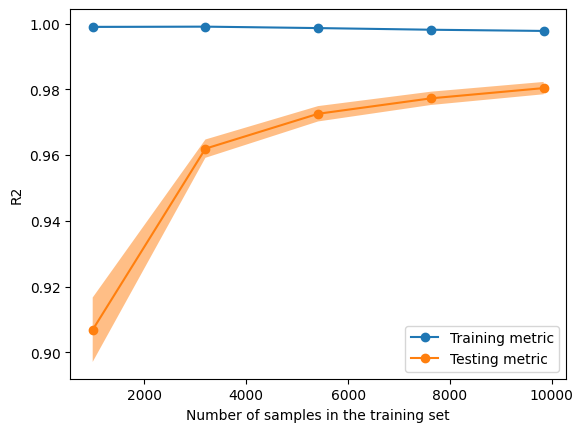

In [325]:
common_params = {
    "X": X_train_tt,
    "y": y_train_tt,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "R2",
}
LearningCurveDisplay.from_estimator(best_estimator, **common_params)
#    '''handles, label = ax[ax_idx].get_legend_handles_labels()
#    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")'''

<AxesSubplot: xlabel='PC_TT_ATU'>

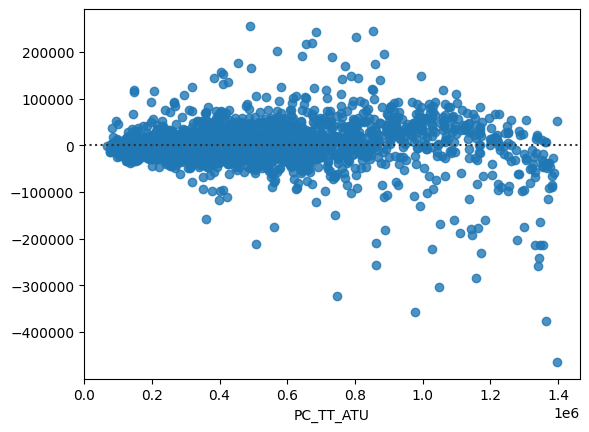

In [324]:
sns.residplot(x=y_test_tt, y=y_pred)